# Libraries

In [279]:
import tensorflow as tf
tf.__version__

'2.12.0'

In [280]:
print(tf.config.list_physical_devices('GPU'))
gpus = tf.config.experimental.list_physical_devices('GPU')
gpus

[]


[]

In [281]:
for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)

In [282]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [283]:
from time import time
import warnings
warnings.filterwarnings('ignore')

import random
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42)

In [284]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, plot_confusion_matrix
#import tensorflow as tf
from tensorflow import keras
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.initializers import RandomUniform

In [285]:
from set_extraction_monks import x_train_m1, y_train_m1, x_test_m1, y_test_m1, x_train_m2, y_train_m2, x_test_m2, y_test_m2, x_train_m3, y_train_m3, x_test_m3, y_test_m3

# Models

In [286]:
def accuracy(y_true, y_pred):
    return accuracy_score(y_true, y_pred)

In [287]:
from sklearn.model_selection import learning_curve

### Bundling our previous work into a function ###
def learning_curves(estimator, x, y, train_sizes, cv):

    train_sizes, train_scores, validation_scores = learning_curve(estimator, x, y, train_sizes=train_sizes,
                                                                cv = cv, scoring='accuracy')
    train_scores_mean = train_scores.mean(axis = 1)
    validation_scores_mean = validation_scores.mean(axis = 1)

    plt.plot(train_sizes, train_scores_mean, label = 'Training error')
    plt.plot(train_sizes, validation_scores_mean, label = 'Validation error', linestyle='dashed')

    plt.ylabel('accuracy', fontsize = 14)
    plt.xlabel('Training set size', fontsize = 14)
    title = 'Learning curves for a ' + str(estimator).split('(')[0] + ' model'
    plt.title(title, fontsize = 10, y = 1.03)
    plt.legend()
    plt.ylim(0,2)

# Neural Networks

## KerasClassifier monk-1

### Grid search for parameter setting 


In [288]:
in_dim = x_train_m1.shape[1]
out_dim = 1 

params = {
    # 'batch_size': [round(x_train_m1.shape[0]*0.8)],
    # 'validation_batch_size': [round(x_train_m1.shape[0]*0.2)], 
    'batch_size': [None],
    'model__dropout_rate': [0], #, 0.1],  
    'model__num_hidden_layers': [1], 
    'model__h_units': [6, 8],  
    'model__learning_rate': [0.8, 0.9], 
    'model__momentum': [0.7, 0.8],
    'model__weight_decay': [None],
    'model__activation': ['relu', 'tanh'] 
}

In [289]:
# define a function to create model
def create_mlp_model(dropout_rate, activation, num_hidden_layers, h_units, learning_rate, momentum, weight_decay): 
    # create model
    model = Sequential()

    model.add(Input(in_dim))    

    # # Add the hidden layers.
    for i in range(1, num_hidden_layers+1):
        model.add(Dense(h_units, activation=activation))
        if dropout_rate != 0:
            model.add(Dropout(rate=dropout_rate))

    model.add(Dense(out_dim, activation='sigmoid')) 

    # Compile model
    model.compile( 
        optimizer= SGD(learning_rate=learning_rate, momentum=momentum, weight_decay=weight_decay),
        loss='mean_squared_error',
        metrics=['accuracy']
        )    
    
    return model

In [290]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
                                patience=20,                              
                                monitor="val_loss",
                                mode='min',
                                restore_best_weights=True,
                                min_delta=0,
                                verbose=1
                                )

In [291]:
# results = []

In [292]:
#hyperparameter tuning with grid search CV
n_jobs_search = -1

start=time()

mlp = KerasClassifier(
                    model=create_mlp_model, 
                    epochs=500, 
                    callbacks=[early_stopping], 
                    validation_split=0.2
                    )

mlp_cv_m1 = GridSearchCV(estimator=mlp, param_grid=params, scoring='accuracy', cv=5, verbose=4, 
                        n_jobs=n_jobs_search, error_score='raise') 

mlp_cv_m1.fit(x_train_m1, y_train_m1) 

print('time for grid search = {:.0f} sec'.format(time()-start))


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Epoch 1/500
4/4 [==============================] - 0s 29ms/step - loss: 0.2552 - accuracy: 0.5354 - val_loss: 0.2642 - val_accuracy: 0.5200
Epoch 2/500
4/4 [==============================] - 0s 11ms/step - loss: 0.2697 - accuracy: 0.4949 - val_loss: 0.2391 - val_accuracy: 0.5600
Epoch 3/500
4/4 [==============================] - 0s 8ms/step - loss: 0.2296 - accuracy: 0.6263 - val_loss: 0.2117 - val_accuracy: 0.6800
Epoch 4/500
4/4 [==============================] - 0s 9ms/step - loss: 0.2005 - accuracy: 0.6465 - val_loss: 0.1814 - val_accuracy: 0.8000
Epoch 5/500
4/4 [==============================] - 0s 5ms/step - loss: 0.1491 - accuracy: 0.8384 - val_loss: 0.1848 - val_accuracy: 0.7200
Epoch 6/500
4/4 [==============================] - 0s 5ms/step - loss: 0.1238 - accuracy: 0.8687 - val_loss: 0.1868 - val_accuracy: 0.7200
Epoch 7/500
4/4 [==============================] - 0s 8ms/step - loss: 0.0941 - accuracy: 0.8586 - val_

In [293]:
mlp_cv_m1.best_params_

{'batch_size': None,
 'model__activation': 'relu',
 'model__dropout_rate': 0,
 'model__h_units': 8,
 'model__learning_rate': 0.9,
 'model__momentum': 0.7,
 'model__num_hidden_layers': 1,
 'model__weight_decay': None}

In [294]:
# validation
mlp_cv_m1.best_score_

0.9280000000000002

## Retraining for 5 iterations and looking for median

In [295]:
# Final retraining -------------------------------------------------------------------------

In [304]:
final_models = []
models_train_mse = []
models_val_mse = []
models_train_acc = []
models_val_acc = []

x_train_m1, x_val_m1, y_train_m1, y_val_m1 = train_test_split(x_train_m1, y_train_m1, test_size=0.2, shuffle=True, stratify=y_train_m1)

for i in range(1,6):

    print("Trial", i)

    model = KerasClassifier(
                        model=create_mlp_model, 
                        epochs=500, 
                        callbacks=[early_stopping], 
                        validation_split=0.2,
                        verbose=0,
                        **mlp_cv_m1.best_params_
                        )
    
    hist = model.fit(x_train_m1, y_train_m1, validation_data=(x_val_m1, y_val_m1))

    models_train_mse.append(hist.history_['loss'])
    models_val_mse.append(hist.history_['val_loss'])
    models_train_acc.append(hist.history_['accuracy'])
    models_val_acc.append(hist.history_['val_accuracy'])

    final_models.append(model)


Trial 1
Trial 2
Trial 3
Trial 4
Trial 5


In [305]:
[el[-1] for el in models_val_acc]

[1.0, 1.0, 1.0, 1.0, 1.0]

In [306]:
last = [el[-1] for el in models_val_mse]
last

[0.01036340743303299,
 0.003312621731311083,
 0.00011802441440522671,
 0.0016414286801591516,
 0.00010620585089782253]

In [307]:
# median model btw 5 trials
final_idx = np.argsort(last)[len(last)//2]
final_idx

3

In [308]:
models_val_acc[final_idx][-1]

1.0

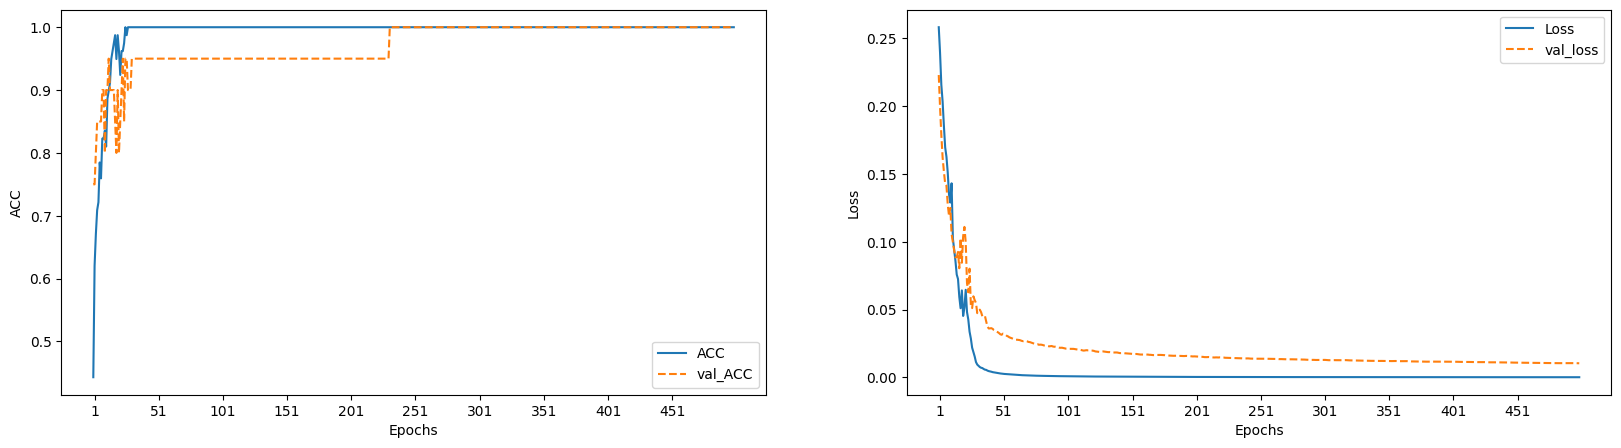

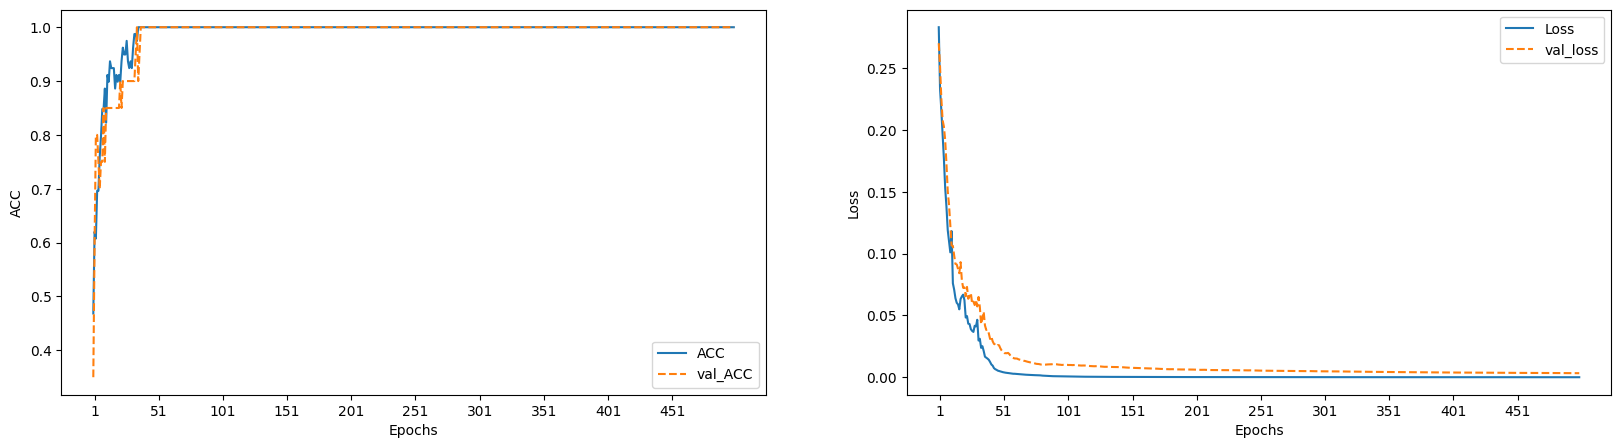

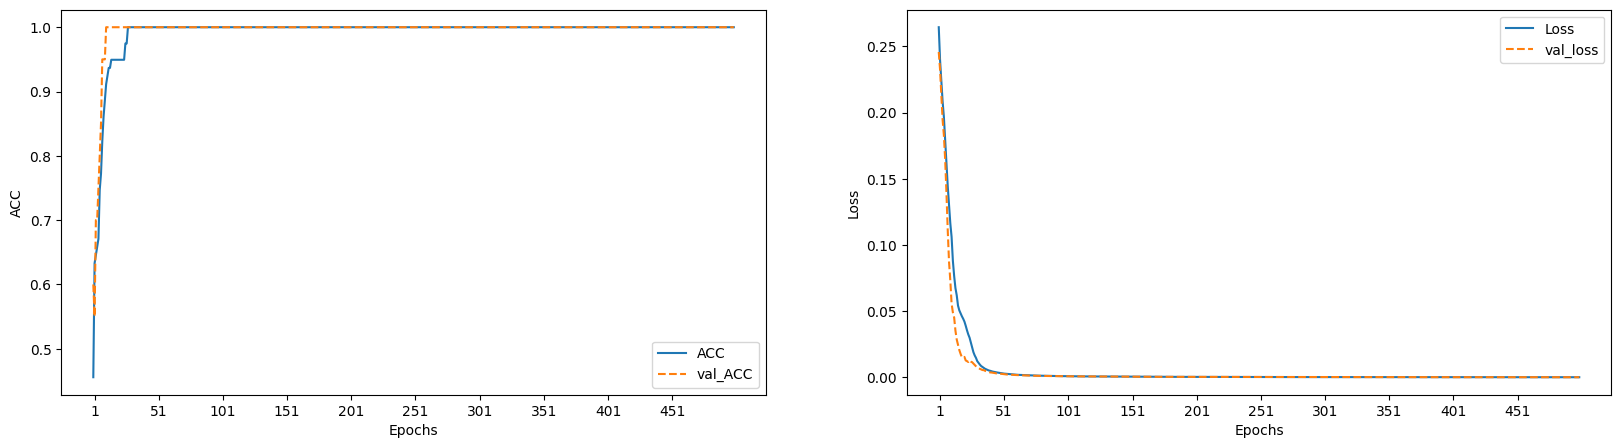

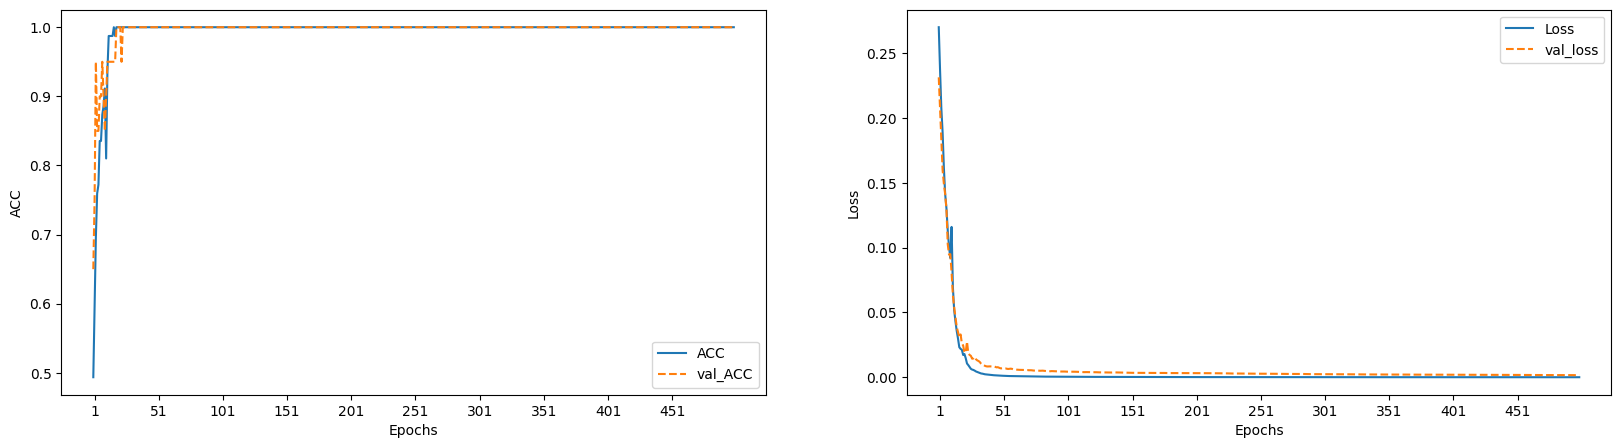

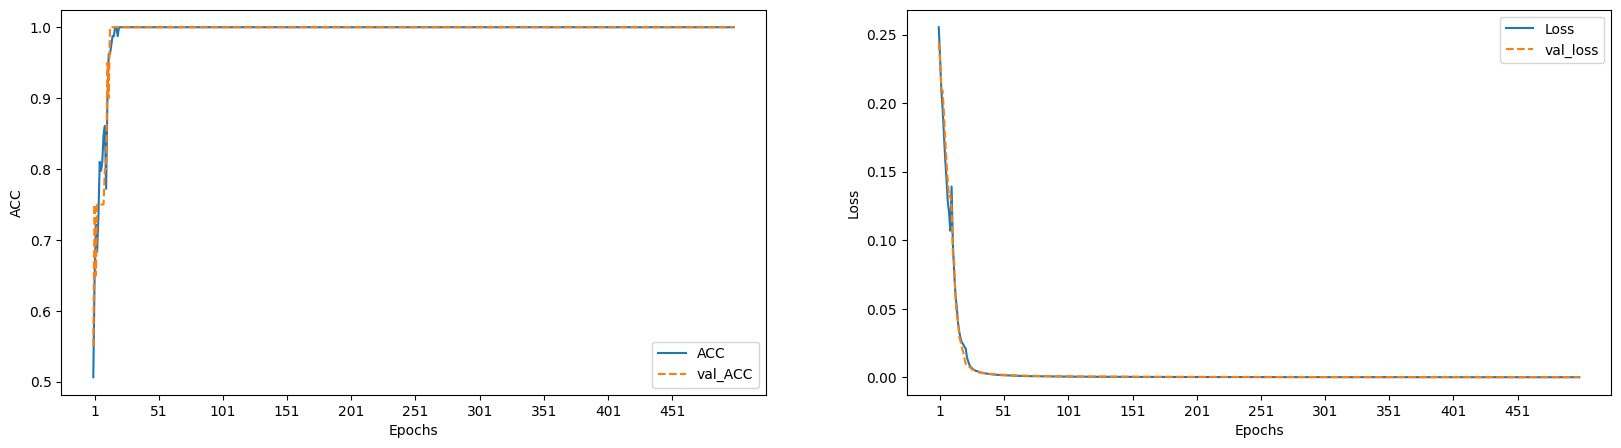

In [309]:
for i in range(5):

        b_ep = len(models_train_acc[i])

        f, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
        #accuracy plot
        axs[0].plot(models_train_acc[i][0:b_ep], label='ACC') 
        axs[0].plot(models_val_acc[i][0:b_ep], label='val_ACC', linestyle='dashed')       
        axs[0].set_xlabel('Epochs')
        axs[0].set_ylabel('ACC')
        #plt.ylim([0,5])
        axs[0].set_xticks(np.arange(1, len(models_train_acc[i][0:b_ep])+1, 50)) 
        axs[0].legend(loc = 'lower right')

        #Loss plot
        axs[1].plot(models_train_mse[i][0:b_ep], label='Loss') 
        axs[1].plot(models_val_mse[i][0:b_ep], label='val_loss', linestyle='dashed')       
        axs[1].set_xlabel('Epochs')
        axs[1].set_ylabel('Loss')
        #plt.ylim([0,5])
        axs[1].set_xticks(np.arange(1, len(models_train_mse[i][0:b_ep])+1, 50))
        axs[1].legend(loc = 'upper right')

        plt.show()

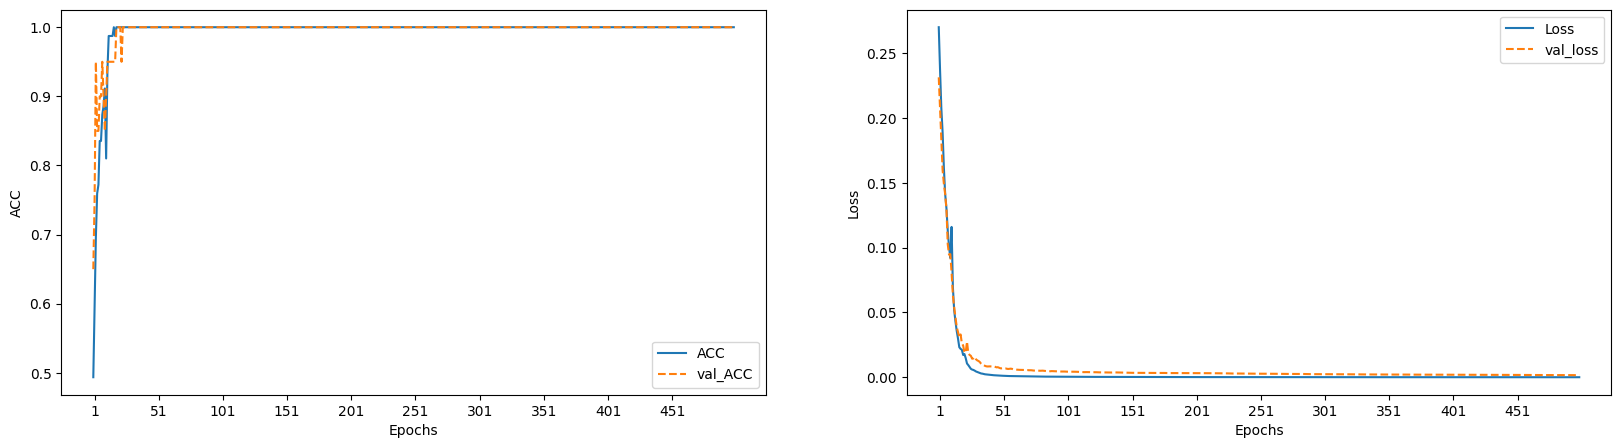

In [310]:
b_ep = len(models_train_acc[final_idx])

f, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
#accuracy plot
axs[0].plot(models_train_acc[final_idx][0:b_ep], label='ACC') 
axs[0].plot(models_val_acc[final_idx][0:b_ep], label='val_ACC', linestyle='dashed')       
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('ACC')
#plt.ylim([0,5])
axs[0].set_xticks(np.arange(1, len(models_train_acc[final_idx][0:b_ep])+1, 50))
axs[0].legend(loc = 'lower right')

#Loss plot
axs[1].plot(models_train_mse[final_idx][0:b_ep], label='Loss') 
axs[1].plot(models_val_mse[final_idx][0:b_ep], label='val_loss', linestyle='dashed')       
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
#plt.ylim([0,5])
axs[1].set_xticks(np.arange(1, len(models_train_mse[final_idx][0:b_ep])+1, 50))
axs[1].legend(loc = 'upper right')

plt.show()

Restoring model weights from the end of the best epoch: 1.
Epoch 21: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 21: early stopping
Restoring model weights from the end of the best epoch: 11.
Epoch 31: early stopping
Restoring model weights from the end of the best epoch: 7.
Epoch 27: early stopping
Restoring model weights from the end of the best epoch: 14.
Epoch 34: early stopping
Restoring model weights from the end of the best epoch: 14.
Epoch 34: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 21: early stopping
Restoring model weights from the end of the best epoch: 134.
Epoch 154: early stopping
Restoring model weights from the end of the best epoch: 39.
Epoch 59: early stopping
Restoring model weights from the end of the best epoch: 479.
Epoch 499: early stopping
Restoring model weights from the end of the best epoch: 4.
Epoch 24: early stopping
Restoring model weights from the end of the best epoch: 2.
Epoch 2

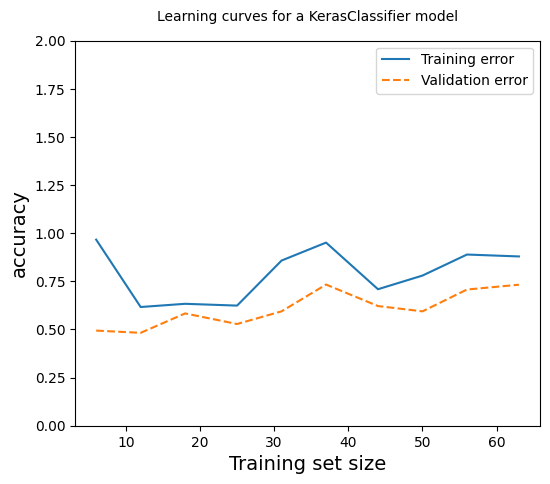

In [311]:
### Plotting the learning curves ###
plt.figure(figsize = (6,5))

learning_curves(final_models[final_idx], x_train_m1, y_train_m1, [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 5)

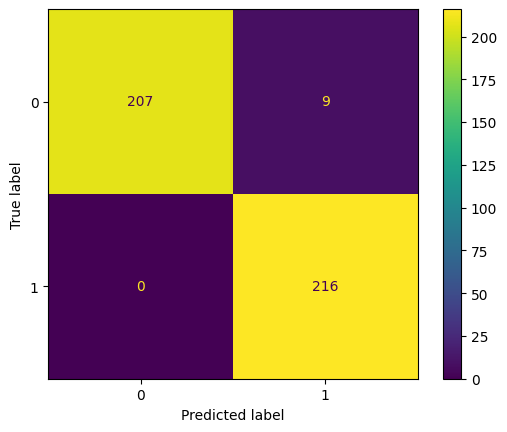

In [312]:
plot_confusion_matrix(final_models[final_idx], x_test_m1, y_test_m1)
plt.show() 

In [313]:
final_models[final_idx].model_.save("monk_models/keras_median_m1.h5")

In [ ]:
# --------------------------------------------------------------------------------------------

### Final model

In [314]:
keras = load_model('monk_models/keras_median_m1.h5')

In [315]:
keras

In [316]:
keras.summary()

Model: "sequential_318"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_636 (Dense)           (None, 8)                 144       
                                                                 
 dense_637 (Dense)           (None, 1)                 9         
                                                                 
Total params: 153
Trainable params: 153
Non-trainable params: 0
_________________________________________________________________


In [317]:
test_pred_keras = (keras.predict(x_test_m1) >= 0.5).astype("int64")

14/14 [==============================] - 0s 617us/step


In [318]:
print('Accuarcy test set')
print(classification_report(y_test_m1, test_pred_keras)) 

Accuarcy test set
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       216
           1       0.96      1.00      0.98       216

    accuracy                           0.98       432
   macro avg       0.98      0.98      0.98       432
weighted avg       0.98      0.98      0.98       432



In [319]:
print(('KerasClassifier monk-1 train', models_train_acc[final_idx][-1]))
print(('KerasClassifier monk-1 validation', models_val_acc[final_idx][-1]))
print(('KerasClassifier monk-1 test', accuracy_score(y_test_m1, test_pred_keras)))

('KerasClassifier monk-1 train', 1.0)
('KerasClassifier monk-1 validation', 1.0)
('KerasClassifier monk-1 test', 0.9791666666666666)


In [35]:
# results

## KerasClassifier monk-2

In [153]:
in_dim = x_train_m2.shape[1]
out_dim = 1 

params = {
    # 'batch_size': [round(x_train_m2.shape[0]*0.8)],
    # 'validation_batch_size': [round(x_train_m2.shape[0]*0.2)], 
    'batch_size': [None],
    'model__dropout_rate': [0], # 0.1],
    'model__num_hidden_layers': [1],  #1
    'model__h_units': [8, 10],  
    'model__learning_rate': [0.1, 0.2], #[0.001, 0.01], 
    'model__momentum': [0.8, 0.9],
    'model__weight_decay': [None],
    'model__activation': ['relu', 'tanh']
}

In [154]:
#hyperparameter tuning with grid search CV
n_jobs_search = -1

start=time()

mlp = KerasClassifier(
                    model=create_mlp_model, 
                    epochs=500, 
                    callbacks=[early_stopping], 
                    validation_split=0.2
                    )

mlp_cv_m2 = GridSearchCV(estimator=mlp, param_grid=params, scoring='accuracy', 
                         cv=5, verbose=4, n_jobs=n_jobs_search, error_score='raise') 

mlp_cv_m2.fit(x_train_m2, y_train_m2) 

print('time for grid search = {:.0f} sec'.format(time()-start))


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Epoch 1/500
5/5 [==============================] - 0s 30ms/step - loss: 0.3086 - accuracy: 0.3778 - val_loss: 0.2466 - val_accuracy: 0.5588
Epoch 2/500
5/5 [==============================] - 0s 7ms/step - loss: 0.2415 - accuracy: 0.6000 - val_loss: 0.2736 - val_accuracy: 0.5588
Epoch 3/500
5/5 [==============================] - 0s 8ms/step - loss: 0.2429 - accuracy: 0.6370 - val_loss: 0.2833 - val_accuracy: 0.5588
Epoch 4/500
5/5 [==============================] - 0s 7ms/step - loss: 0.2406 - accuracy: 0.6370 - val_loss: 0.2672 - val_accuracy: 0.5588
Epoch 5/500
5/5 [==============================] - 0s 7ms/step - loss: 0.2310 - accuracy: 0.6370 - val_loss: 0.2525 - val_accuracy: 0.5588
Epoch 6/500
5/5 [==============================] - 0s 9ms/step - loss: 0.2263 - accuracy: 0.6444 - val_loss: 0.2479 - val_accuracy: 0.5882
Epoch 7/500
5/5 [==============================] - 0s 8ms/step - loss: 0.2231 - accuracy: 0.6370 - val_l

In [155]:
mlp_cv_m2.best_params_

{'batch_size': None,
 'model__activation': 'relu',
 'model__dropout_rate': 0,
 'model__h_units': 8,
 'model__learning_rate': 0.2,
 'model__momentum': 0.9,
 'model__num_hidden_layers': 1,
 'model__weight_decay': None}

In [156]:
# validation
mlp_cv_m2.best_score_

1.0

## Retraining for 5 iterations and looking for median

In [157]:
# Final retraining -------------------------------------------------------------------------

In [158]:
final_models = []
models_train_mse = []
models_val_mse = []
models_train_acc = []
models_val_acc = []

x_train_m2, x_val_m2, y_train_m2, y_val_m2 = train_test_split(x_train_m2, y_train_m2, test_size=0.2, shuffle=True, stratify=y_train_m2)

for i in range(1,6):

    print("Trial", i)

    model = KerasClassifier(
                        model=create_mlp_model, 
                        epochs=500, 
                        callbacks=[early_stopping], 
                        validation_split=0.2,
                        verbose=0,
                        **mlp_cv_m2.best_params_
                        )
    
    hist = model.fit(x_train_m2, y_train_m2, validation_data=(x_val_m2, y_val_m2))

    models_train_mse.append(hist.history_['loss'])
    models_val_mse.append(hist.history_['val_loss'])
    models_train_acc.append(hist.history_['accuracy'])
    models_val_acc.append(hist.history_['val_accuracy'])

    final_models.append(model)


Trial 1
Trial 2
Trial 3
Trial 4
Restoring model weights from the end of the best epoch: 1.
Epoch 21: early stopping
Trial 5


In [159]:
[el[-1] for el in models_val_acc]

[1.0, 1.0, 1.0, 0.529411792755127, 1.0]

In [160]:
last = [el[-1] for el in models_val_mse]
last

[0.00018829070904757828,
 0.0005515236407518387,
 0.000159263945533894,
 0.24186620116233826,
 7.329545042011887e-05]

In [161]:
# median model btw 5 trials
final_idx = np.argsort(last)[len(last)//2]
final_idx

0

In [162]:
models_val_acc[final_idx][-1]

1.0

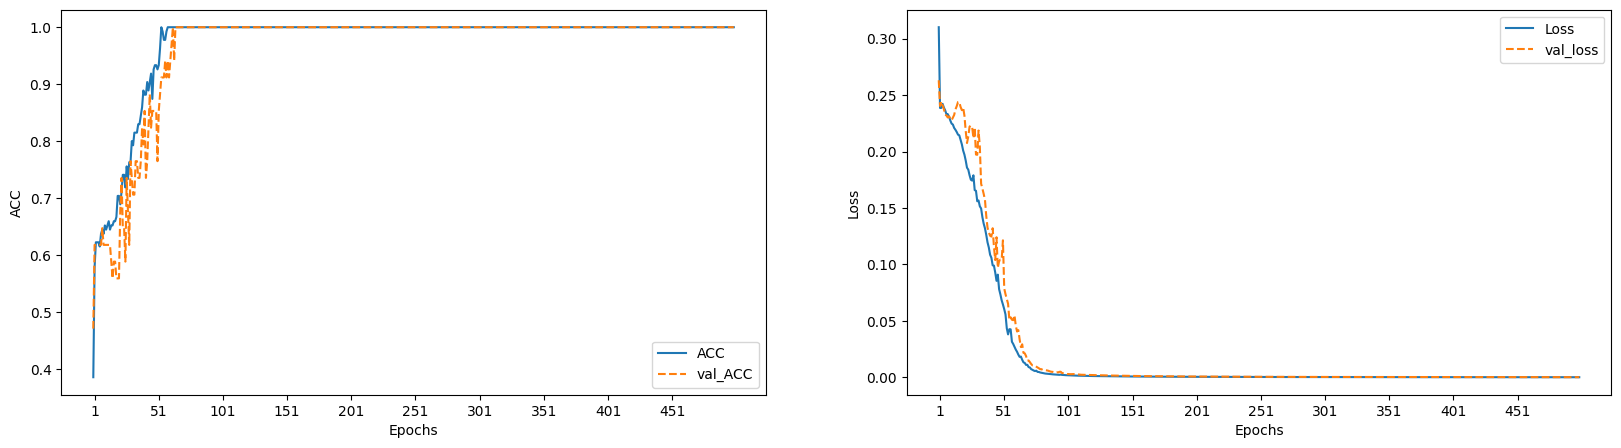

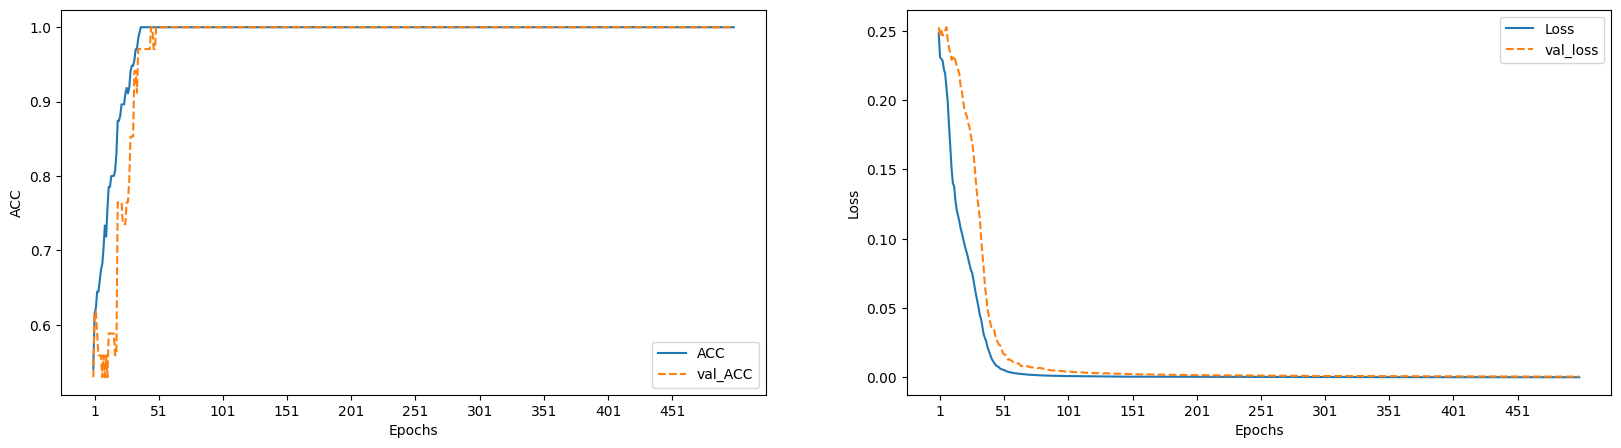

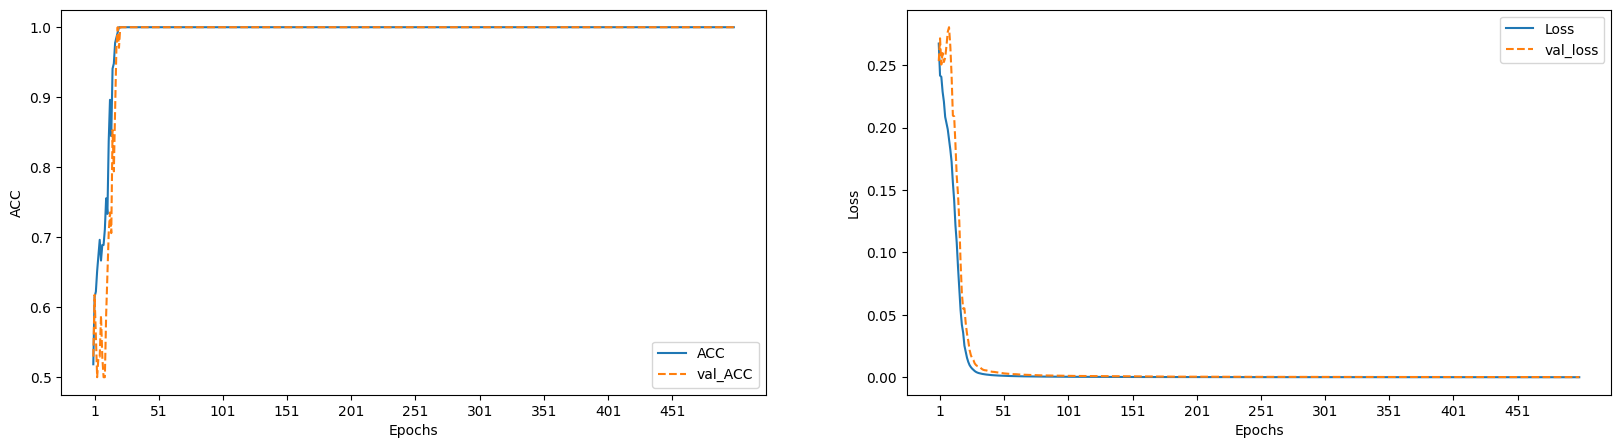

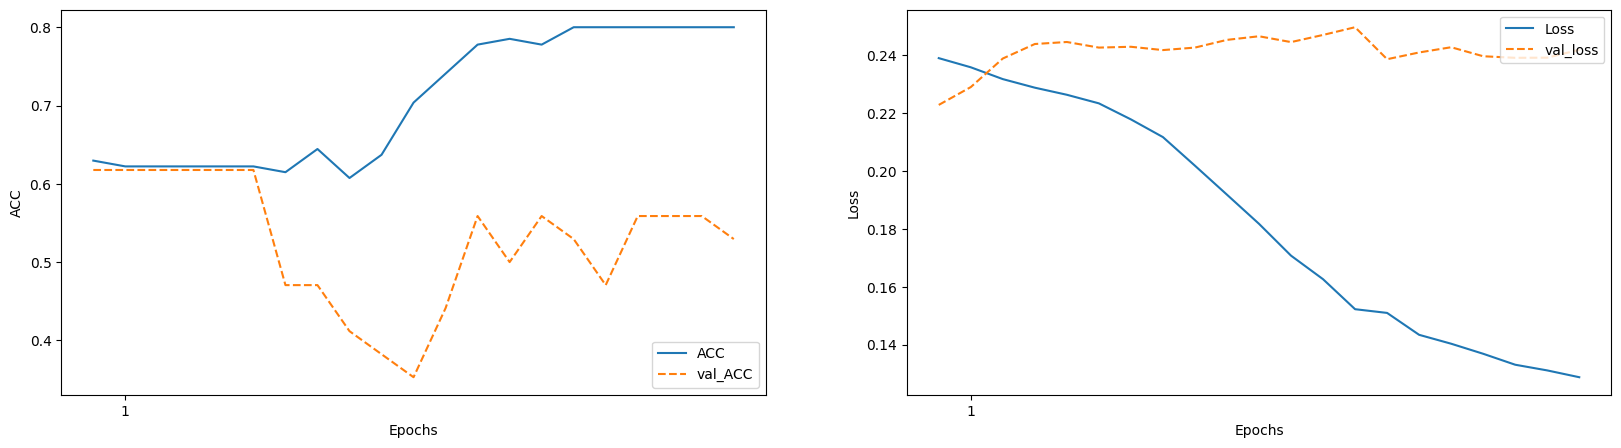

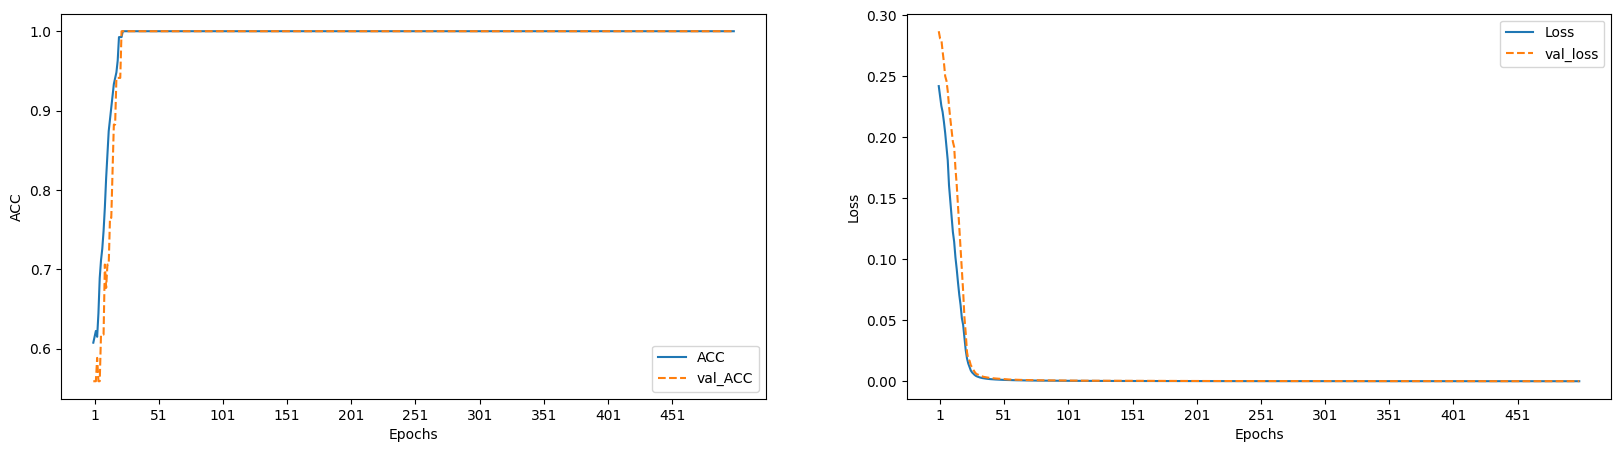

In [163]:
for i in range(5):

        b_ep = len(models_train_acc[i])

        f, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
        #accuracy plot
        axs[0].plot(models_train_acc[i][0:b_ep], label='ACC') 
        axs[0].plot(models_val_acc[i][0:b_ep], label='val_ACC', linestyle='dashed')       
        axs[0].set_xlabel('Epochs')
        axs[0].set_ylabel('ACC')
        #plt.ylim([0,5])
        axs[0].set_xticks(np.arange(1, len(models_train_acc[i][0:b_ep])+1, 50)) 
        axs[0].legend(loc = 'lower right')

        #Loss plot
        axs[1].plot(models_train_mse[i][0:b_ep], label='Loss') 
        axs[1].plot(models_val_mse[i][0:b_ep], label='val_loss', linestyle='dashed')       
        axs[1].set_xlabel('Epochs')
        axs[1].set_ylabel('Loss')
        #plt.ylim([0,5])
        axs[1].set_xticks(np.arange(1, len(models_train_mse[i][0:b_ep])+1, 50))
        axs[1].legend(loc = 'upper right')

        plt.show()

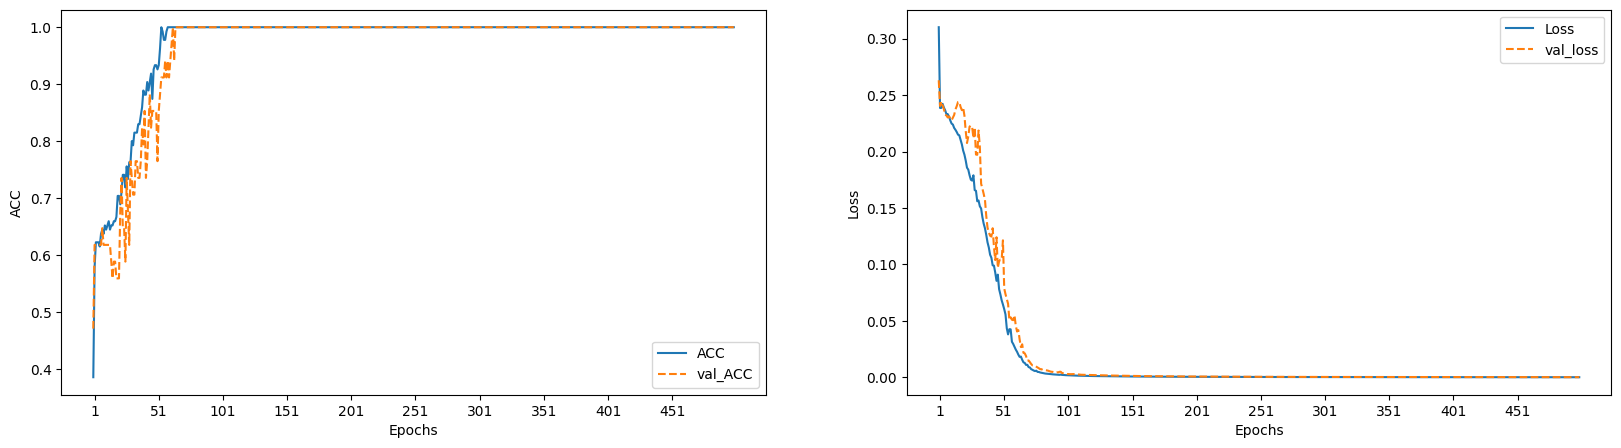

In [164]:
b_ep = len(models_train_acc[final_idx])

f, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
#accuracy plot
axs[0].plot(models_train_acc[final_idx][0:b_ep], label='ACC') 
axs[0].plot(models_val_acc[final_idx][0:b_ep], label='val_ACC', linestyle='dashed')       
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('ACC')
#plt.ylim([0,5])
axs[0].set_xticks(np.arange(1, len(models_train_acc[final_idx][0:b_ep])+1, 50))
axs[0].legend(loc = 'lower right')

#Loss plot
axs[1].plot(models_train_mse[final_idx][0:b_ep], label='Loss') 
axs[1].plot(models_val_mse[final_idx][0:b_ep], label='val_loss', linestyle='dashed')       
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
#plt.ylim([0,5])
axs[1].set_xticks(np.arange(1, len(models_train_mse[final_idx][0:b_ep])+1, 50))
axs[1].legend(loc = 'upper right')

plt.show()

Restoring model weights from the end of the best epoch: 5.
Epoch 25: early stopping
Restoring model weights from the end of the best epoch: 3.
Epoch 23: early stopping
Restoring model weights from the end of the best epoch: 2.
Epoch 22: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 21: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 21: early stopping
Restoring model weights from the end of the best epoch: 8.
Epoch 28: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 21: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 21: early stopping
Restoring model weights from the end of the best epoch: 4.
Epoch 24: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 21: early stopping
Restoring model weights from the end of the best epoch: 9.
Epoch 29: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 21: early s

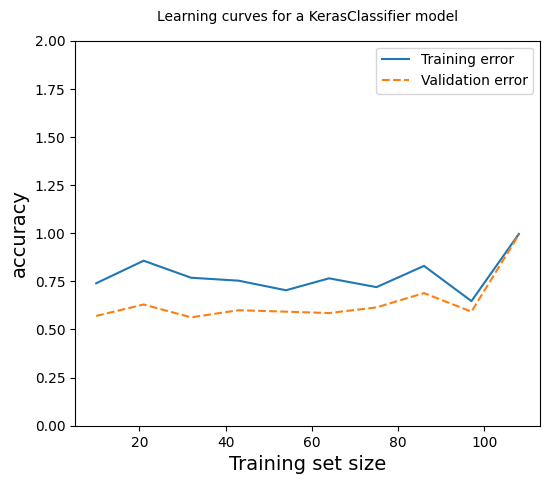

In [165]:
### Plotting the learning curves ###
plt.figure(figsize = (6,5))

learning_curves(final_models[final_idx], x_train_m2, y_train_m2, [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 5)

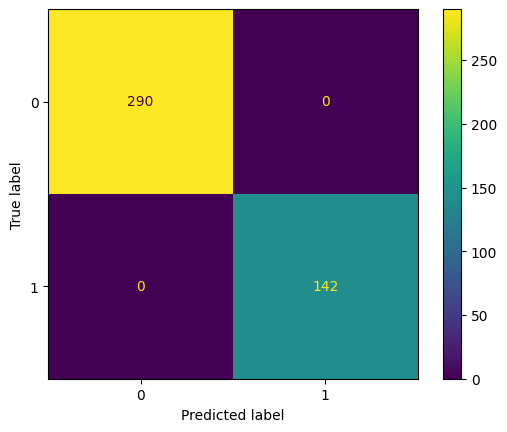

In [166]:
plot_confusion_matrix(final_models[final_idx], x_test_m2, y_test_m2)
plt.show() 

In [167]:
final_models[final_idx].model_.save("monk_models/keras_median_m2.h5")

In [168]:
# --------------------------------------------------------------------------------------------

### Final model

In [215]:
keras = load_model('monk_models/keras_median_m2.h5')

In [216]:
keras

In [217]:
keras.summary()

Model: "sequential_101"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_202 (Dense)           (None, 8)                 144       
                                                                 
 dense_203 (Dense)           (None, 1)                 9         
                                                                 
Total params: 153
Trainable params: 153
Non-trainable params: 0
_________________________________________________________________


In [218]:
test_pred_keras = (keras.predict(x_test_m2) >= 0.5).astype("int64")

14/14 [==============================] - 0s 964us/step


In [219]:
print('Accuarcy test set')
print(classification_report(y_test_m2, test_pred_keras))

Accuarcy test set
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       290
           1       1.00      1.00      1.00       142

    accuracy                           1.00       432
   macro avg       1.00      1.00      1.00       432
weighted avg       1.00      1.00      1.00       432



In [174]:
print(('KerasClassifier monk-2 train', models_train_acc[final_idx][-1]))
print(('KerasClassifier monk-2 validation', models_val_acc[final_idx][-1]))
print(('KerasClassifier monk-2 test', accuracy_score(y_test_m2, test_pred_keras)))

('KerasClassifier monk-2 train', 1.0)
('KerasClassifier monk-2 validation', 1.0)
('KerasClassifier monk-2 test', 1.0)


In [175]:
# results

## KerasClassifier monk-3

In [190]:
in_dim = x_train_m3.shape[1]
out_dim = 1

params = {
    # 'batch_size': [round(x_train_m3.shape[0]*0.8)],
    # 'validation_batch_size': [round(x_train_m3.shape[0]*0.2)],
    'batch_size': [None],
    'model__dropout_rate': [0, 0.1], 
    'model__num_hidden_layers': [1], 
    'model__h_units': [12, 16],  
    'model__learning_rate': [0.01, 0.1], 
    'model__momentum': [0.6, 0.7, 0.8],
    'model__weight_decay': [0.001, 0.01],
    'model__activation': ['relu', 'tanh']
}

In [191]:
#hyperparameter tuning with grid search CV
n_jobs_search = -1

start=time()

mlp = KerasClassifier(
                    model=create_mlp_model, 
                    epochs=500, 
                    callbacks=[early_stopping], 
                    validation_split=0.2
                    )

mlp_cv_m3 = GridSearchCV(estimator=mlp, param_grid=params, scoring='accuracy', 
                         cv=5, verbose=4, n_jobs=n_jobs_search, error_score='raise') 

mlp_cv_m3.fit(x_train_m3, y_train_m3) 

print('time for grid search = {:.0f} sec'.format(time()-start))


Fitting 5 folds for each of 96 candidates, totalling 480 fits
Epoch 1/500
4/4 [==============================] - 0s 43ms/step - loss: 0.2758 - accuracy: 0.4536 - val_loss: 0.2135 - val_accuracy: 0.6400
Epoch 2/500
4/4 [==============================] - 0s 11ms/step - loss: 0.2723 - accuracy: 0.4742 - val_loss: 0.2120 - val_accuracy: 0.6400
Epoch 3/500
4/4 [==============================] - 0s 11ms/step - loss: 0.2646 - accuracy: 0.4639 - val_loss: 0.2103 - val_accuracy: 0.6800
Epoch 4/500
4/4 [==============================] - 0s 12ms/step - loss: 0.2553 - accuracy: 0.4742 - val_loss: 0.2088 - val_accuracy: 0.6800
Epoch 5/500
4/4 [==============================] - 0s 10ms/step - loss: 0.2464 - accuracy: 0.5258 - val_loss: 0.2082 - val_accuracy: 0.6800
Epoch 6/500
4/4 [==============================] - 0s 11ms/step - loss: 0.2412 - accuracy: 0.5464 - val_loss: 0.2079 - val_accuracy: 0.7200
Epoch 7/500
4/4 [==============================] - 0s 11ms/step - loss: 0.2372 - accuracy: 0.6082 

In [192]:
mlp_cv_m3.best_params_

{'batch_size': None,
 'model__activation': 'relu',
 'model__dropout_rate': 0,
 'model__h_units': 12,
 'model__learning_rate': 0.01,
 'model__momentum': 0.7,
 'model__num_hidden_layers': 1,
 'model__weight_decay': 0.001}

In [193]:
# validation
mlp_cv_m3.best_score_

0.9339999999999999

## Retraining for 5 iterations and looking for median

In [194]:
# Final retraining -------------------------------------------------------------------------

In [195]:
final_models = []
models_train_mse = []
models_val_mse = []
models_train_acc = []
models_val_acc = []

x_train_m3, x_val_m3, y_train_m3, y_val_m3 = train_test_split(x_train_m3, y_train_m3, test_size=0.2, shuffle=True, stratify=y_train_m3)

for i in range(1,6):

    print("Trial", i)

    model = KerasClassifier(
                        model=create_mlp_model, 
                        epochs=500, 
                        callbacks=[early_stopping], 
                        validation_split=0.2,
                        verbose=0,
                        **mlp_cv_m3.best_params_
                        )
    
    hist = model.fit(x_train_m3, y_train_m3, validation_data=(x_val_m3, y_val_m3))

    models_train_mse.append(hist.history_['loss'])
    models_val_mse.append(hist.history_['val_loss'])
    models_train_acc.append(hist.history_['accuracy'])
    models_val_acc.append(hist.history_['val_accuracy'])

    final_models.append(model)


Trial 1
Restoring model weights from the end of the best epoch: 300.
Epoch 320: early stopping
Trial 2
Restoring model weights from the end of the best epoch: 468.
Epoch 488: early stopping
Trial 3
Restoring model weights from the end of the best epoch: 470.
Epoch 490: early stopping
Trial 4
Restoring model weights from the end of the best epoch: 388.
Epoch 408: early stopping
Trial 5
Restoring model weights from the end of the best epoch: 387.
Epoch 407: early stopping


In [196]:
[el[-1] for el in models_val_acc]

[0.9200000166893005,
 0.9200000166893005,
 0.9200000166893005,
 0.9200000166893005,
 0.9200000166893005]

In [197]:
last = [el[-1] for el in models_val_mse]
last

[0.07170853763818741,
 0.0698220357298851,
 0.07247117161750793,
 0.07033418118953705,
 0.06723938882350922]

In [198]:
# median model btw 5 trials
final_idx = np.argsort(last)[len(last)//2]
final_idx

3

In [199]:
models_val_acc[final_idx][-1]

0.9200000166893005

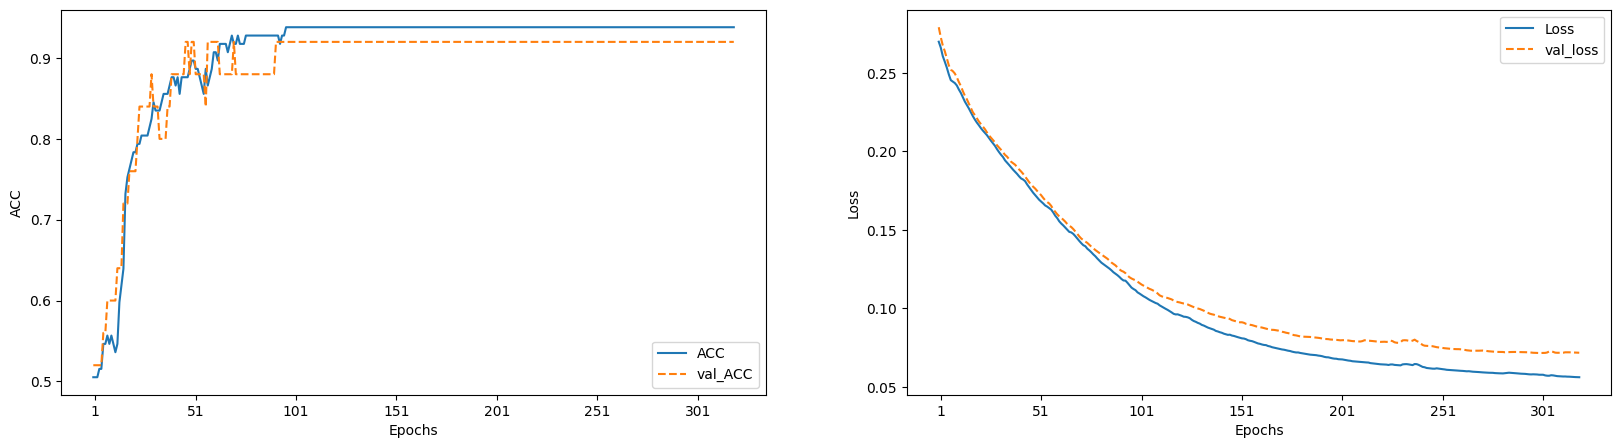

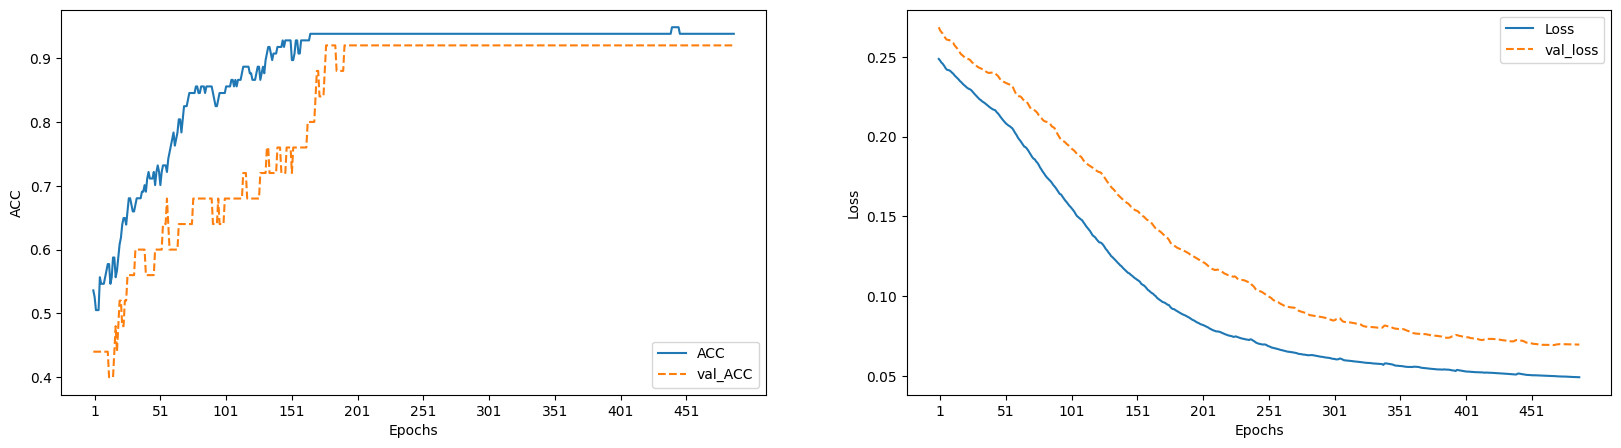

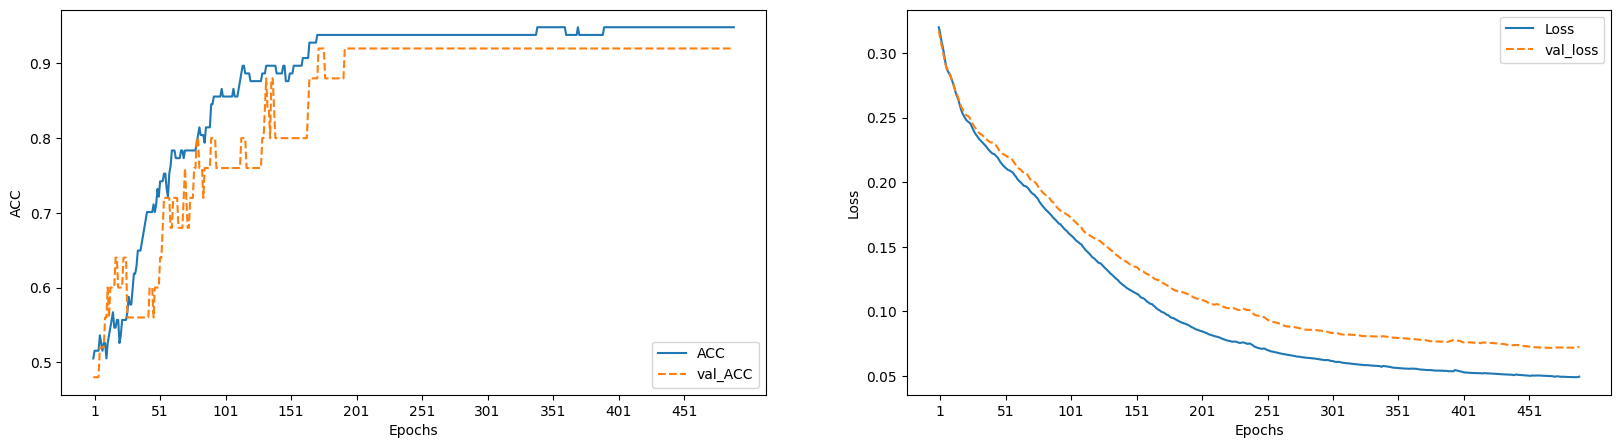

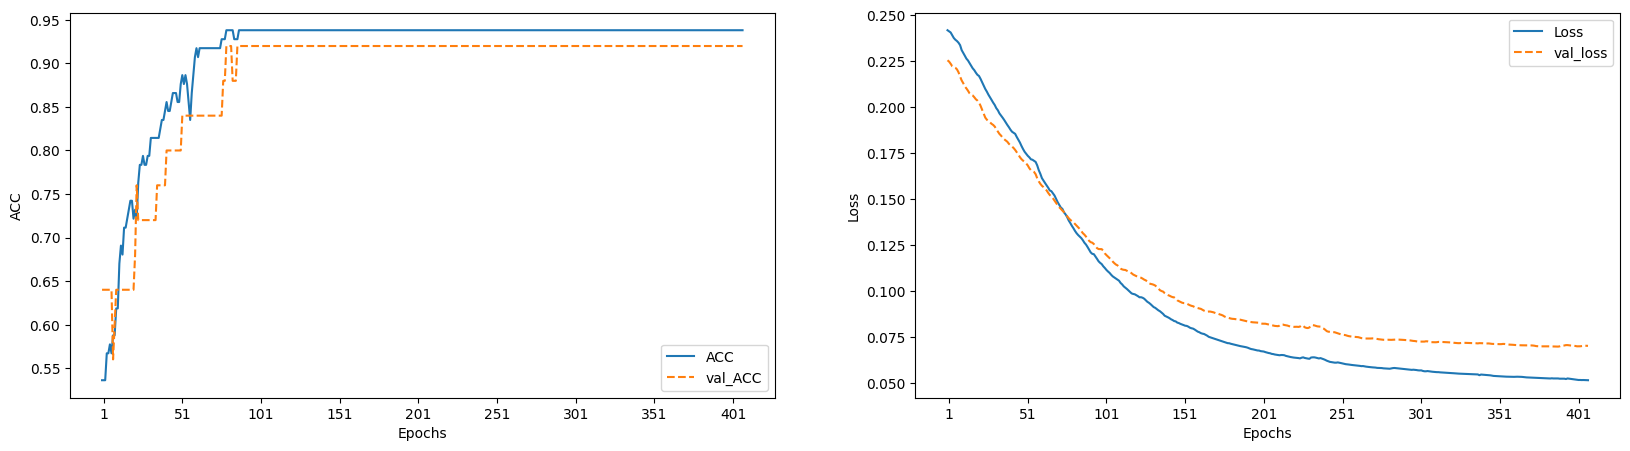

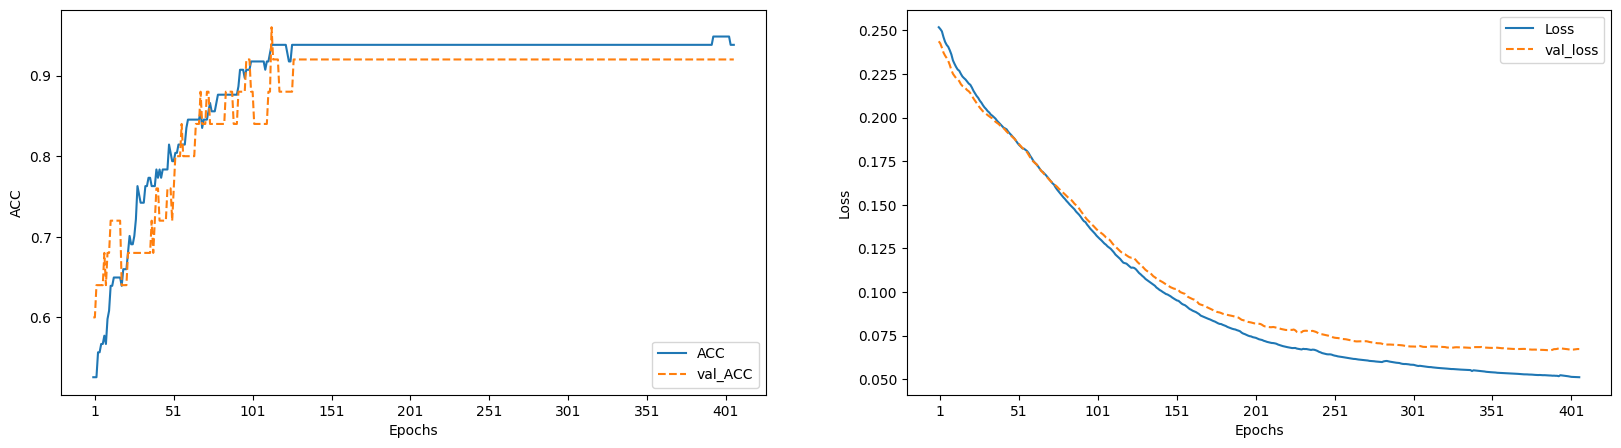

In [200]:
for i in range(5):

        b_ep = len(models_train_acc[i])

        f, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
        #accuracy plot
        axs[0].plot(models_train_acc[i][0:b_ep], label='ACC') 
        axs[0].plot(models_val_acc[i][0:b_ep], label='val_ACC', linestyle='dashed')       
        axs[0].set_xlabel('Epochs')
        axs[0].set_ylabel('ACC')
        #plt.ylim([0,5])
        axs[0].set_xticks(np.arange(1, len(models_train_acc[i][0:b_ep])+1, 50)) 
        axs[0].legend(loc = 'lower right')

        #Loss plot
        axs[1].plot(models_train_mse[i][0:b_ep], label='Loss') 
        axs[1].plot(models_val_mse[i][0:b_ep], label='val_loss', linestyle='dashed')       
        axs[1].set_xlabel('Epochs')
        axs[1].set_ylabel('Loss')
        #plt.ylim([0,5])
        axs[1].set_xticks(np.arange(1, len(models_train_mse[i][0:b_ep])+1, 50))
        axs[1].legend(loc = 'upper right')

        plt.show()

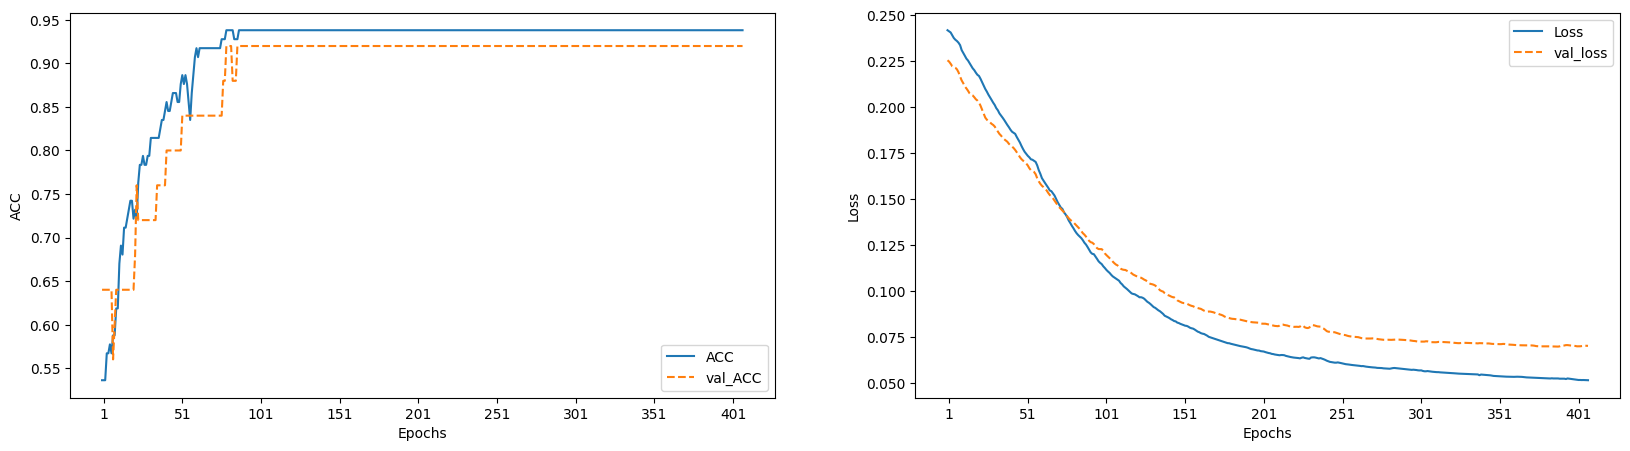

In [201]:
b_ep = len(models_train_acc[final_idx])

f, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
#accuracy plot
axs[0].plot(models_train_acc[final_idx][0:b_ep], label='ACC') 
axs[0].plot(models_val_acc[final_idx][0:b_ep], label='val_ACC', linestyle='dashed')       
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('ACC')
#plt.ylim([0,5])
axs[0].set_xticks(np.arange(1, len(models_train_acc[final_idx][0:b_ep])+1, 50))
axs[0].legend(loc = 'lower right')

#Loss plot
axs[1].plot(models_train_mse[final_idx][0:b_ep], label='Loss') 
axs[1].plot(models_val_mse[final_idx][0:b_ep], label='val_loss', linestyle='dashed')       
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
#plt.ylim([0,5])
axs[1].set_xticks(np.arange(1, len(models_train_mse[final_idx][0:b_ep])+1, 50))
axs[1].legend(loc = 'upper right')

plt.show()

Restoring model weights from the end of the best epoch: 293.
Epoch 313: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 21: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 21: early stopping
Restoring model weights from the end of the best epoch: 43.
Epoch 63: early stopping
Restoring model weights from the end of the best epoch: 118.
Epoch 138: early stopping
Restoring model weights from the end of the best epoch: 14.
Epoch 34: early stopping
Restoring model weights from the end of the best epoch: 468.
Epoch 488: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 21: early stopping
Restoring model weights from the end of the best epoch: 180.
Epoch 200: early stopping
Restoring model weights from the end of the best epoch: 364.
Epoch 384: early stopping
Restoring model weights from the end of the best epoch: 5.
Epoch 25: early stopping
Restoring model weights from the end of the best epoch: 69.

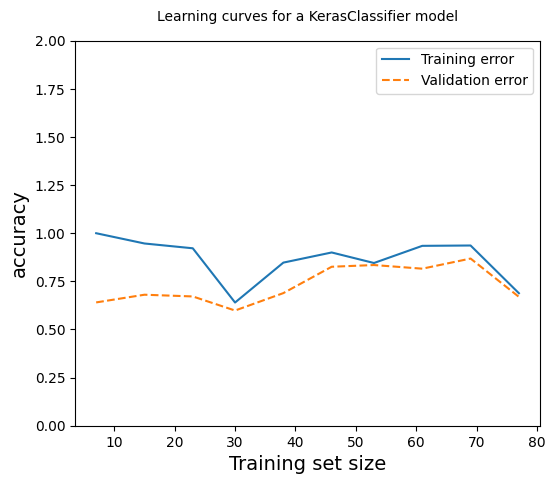

In [202]:
### Plotting the learning curves ###
plt.figure(figsize = (6,5))

learning_curves(final_models[final_idx], x_train_m3, y_train_m3, [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 5)

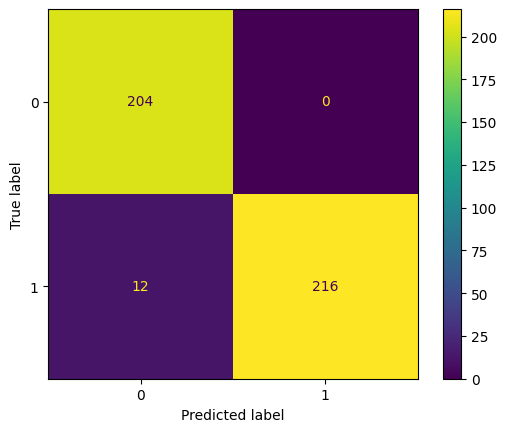

In [203]:
plot_confusion_matrix(final_models[final_idx], x_test_m3, y_test_m3)
plt.show() 

In [204]:
final_models[final_idx].model_.save("monk_models/keras_median_m3.h5")

In [205]:
# --------------------------------------------------------------------------------------------

### Final model

In [206]:
keras = load_model('monk_models/keras_median_m3.h5')

In [207]:
keras

In [208]:
keras.summary()

Model: "sequential_160"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_320 (Dense)           (None, 12)                216       
                                                                 
 dense_321 (Dense)           (None, 1)                 13        
                                                                 
Total params: 229
Trainable params: 229
Non-trainable params: 0
_________________________________________________________________


In [209]:
test_pred_keras = (keras.predict(x_test_m3) >= 0.5).astype("int64")

14/14 [==============================] - 0s 654us/step


In [214]:
print('Accuarcy test set')
print(classification_report(y_test_m3, test_pred_keras)) 

Accuarcy test set
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       204
           1       1.00      0.95      0.97       228

    accuracy                           0.97       432
   macro avg       0.97      0.97      0.97       432
weighted avg       0.97      0.97      0.97       432



In [211]:
print(('KerasClassifier monk-3 train', models_train_acc[final_idx][-1]))
print(('KerasClassifier monk-3 validation', models_val_acc[final_idx][-1]))
print(('KerasClassifier monk-3 test', accuracy_score(y_test_m3, test_pred_keras)))

('KerasClassifier monk-3 train', 0.938144326210022)
('KerasClassifier monk-3 validation', 0.9200000166893005)
('KerasClassifier monk-3 test', 0.9722222222222222)


In [212]:
# results

# Summary

In [213]:
# for i in range(len(results)):
#   print(results[i])